## Faculdade de Engenharia de Sorocaba
## Trabalho de conclusão de curso
## Previsão do risco de morte após uma operação cardíaca utilizando o EuroSCORE

O EuroSCORE (Sistema Europeu de Risco em Operações Cardíacas) é um modelo que permite o cálculo do risco de morte após uma operação cardíaca.  
O modelo solicita alguns itens de informação sobre o paciente, o estado do coração e a operação proposta, e utiliza regressão para calcular o risco de morte.  

Base de dados  
https://plos.figshare.com/articles/Is_the_EuroSCORE_II_reliable_to_estimate_operative_mortality_among_octogenarians_/5608465  
  
### Alunos
- Edson Pires Nunes
- Marcelo Fernandes

## Pendências documentação

- Melhorar a documentação dos gráficos, baseado nas explicações do Johannes.
- Colocar resultados relevantes do EAD.html aqui no notebook.
- Colocar as descrições da base de dados.

### Tópicos para a documentação formato TCC
- Introdução
  - O que é o es2?
  - Por que ele é importante?
  - Por que escolhemos?
- Metodologia
  - Já está explicado nas células. Adicionar as melhorias.
- Trabalhos relacionados / Exemplos literatura
- Conclusão
- Referências

## Pendências programação

- Verificar o dummies:
    - Talvez não seja preciso fazer na geração da base raw_data, pois o setup já aplica algo parecido.
    - Dropar colunas desnecessárias (drop first)
    - Verificar se o dummies pegou as colunas binárias certas
- Verificar se é necessária a função tune_model, pois aumentou o erro... Verificar overfiting.
- No final, comparar o resultado predito com o real graficamente.

## Importação das bibliotecas

O <b>Pandas Profiling</b> é uma ferramenta que gera um relatório html com informações estatísticas e as principais características do seu dataframe.

<p>O <b>PyCaret</b> é uma biblioteca de aprendizado de máquina de código aberto que permite ir desde a preparação de seus dados até a implantação de seu modelo.
<br>A ideia do PyCaret é simplificar o trabalho e automatizar tarefas de rotina, aumentando a produtividade e permitindo entregar soluções mais rapidamente.

In [1]:
import pandas as pd
import numpy as np
import os.path
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas_profiling
from pycaret.regression import *
from pycaret.utils import check_metric
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

## Definição das funções

In [2]:
#Função para normalizar texto
def normalize_text(txt):
    return txt.lstrip().rstrip().lower().replace(" ", "_").replace("/", "_or_").replace("%", "_percent_").replace(".", "_dot_").replace("<>", "_different_").replace("-", "_less_").replace("+", "_plus_").replace(">", "_larger_than_").replace("<", "_less_than_")

# Função para tratamento dos nomes das colunas
def clean_dataframe_column_names(df):
    return [normalize_text(col) for col in df.columns]

# Função para salvar o arquivo com a análise exploratória dos dados (EDA - Exploratory Data Analysis)
def save_eda(fileName, df):
    if not os.path.isfile(fileName):
        pfr = pandas_profiling.ProfileReport(df)
        pfr.to_file(fileName)
    else:
        print (f"EDA already saved, please check {fileName}.")

## Importação da base de dados
## Análise exploratória e descritiva

Algumas das principais informações que o pandas profiling nos fornece:
- Qual o tamanho do dataset
- Quantidade de linhas duplicadas
- Quantidade de linhas do dataframe
- Quantidade de linhas por colunas
- O tipo de dado de cada coluna
- Quais colunas contém missing values
- Qual a distribuição das colunas numéricas

A análise exploratória de dados nos permite extrair informações relevantes sobre o conjunto de dados que estamos trabalhando e o pandas profiling é uma ótima ferramenta para agilizar essa tarefa.  
Em poucos minutos conseguimos gerar informações detalhadas sobre os dados aumentando a nossa produtividade no dia a dia.

## Pré-processamento

In [3]:
# Raw Data: "Dados crus"
# Base de dados revisada em 24/04/2020
# Total de 7161 observações
raw_data = pd.read_excel("data/raw/Euroscore.xls")

# Salvando o arquivo com a análise exploratória dos dados "crus"
save_eda("EDA_Raw.html", raw_data)

# Preenchendo os valores NaN com a média
pre_data = raw_data.fillna(raw_data.mean())

# Preenchendo os valores string com "No" (Valor mais provável)
pre_data = pre_data.fillna("no")

# Remover duplicadas (1 observação)
pre_data.drop_duplicates(inplace=True)

# Variáveis binárias de Yes/No para 1/0
for cl in pre_data.select_dtypes(include=["object"]):
    pre_data[cl] = pre_data[cl].apply(lambda _: str(_).lower())
    if pre_data.groupby(cl)[cl].nunique().count() == 2:
        pre_data[cl] = pre_data[cl].map(dict(yes=1, no=0)).fillna(pre_data[cl])

#Normalização das strings
pre_data = pre_data.applymap(lambda s:normalize_text(s) if type(s) == str else s)

# Limpeza do nome das colunas
pre_data.columns = clean_dataframe_column_names(pre_data)

# Backup em CSV
pre_data.to_csv("data\processed\pre_processed.csv", index=False)

# Liberar memória para a variável não usada
del raw_data
del pre_data

# Carregar o CSV previamente salvo
pre_processed_data = pd.read_csv("data\processed\pre_processed.csv")

# Salvando o arquivo com a análise exploratória dos dados pré-processados
save_eda("EDA_Pre_Processed.html", pre_processed_data)

EDA already saved, please check EDA_Raw.html.
EDA already saved, please check EDA_Pre_Processed.html.


# Processamento (remoção de colunas)
## Não serão usadas na análise
es1: Vamos usar o ES2  
d30death / intrahospitaldeath: Desconsiderar mortes  
## Alta correlação
aa2: é correlacionada com aa, sendo que a segunda varia um pouco mais  
clearancecock: é correlacionada com clearance, sendo que a segunda é arredondada para XX casas decimais  
procedure: é correlacionada com surg, sendo que a segunda indica quantos procecimentos o paciente já teve  
neurologic_dysfunction_a: é igual a neurologic_dysfunction  
activeendocarditis_b: é igual a activeendocarditis  
urgency_a: igual a urgency  
valvularsurgery: mesma informação da valvulopathy

In [4]:
colsToDrop = ["es1","d30death","intrahospitaldeath","aa2", "clearancecock", "procedure", "neurologic_dysfunction_a", "activeendocarditis_b", "urgency_a", "valvularsurgery"]
pre_processed_data = pre_processed_data.drop(colsToDrop, axis=1)

In [5]:
# Salvar dados processados em CSV
pre_processed_data.to_csv("data\processed\processed.csv", index=False)

# Liberar memória
del pre_processed_data

In [6]:
# Carregar CSV previamente salvo
processed_data = pd.read_csv("data\processed\processed.csv")

## Divisão da base para treinamento, teste e validação.

Separação em treinamento e validação (Posteriormente a parte de treino será dividida em treino e teste automaticamente pela função setup do PyCaret)

In [7]:
data_train, data_validation = train_test_split(processed_data, test_size=0.3, random_state=42)

## Regressão

Utilizamos o modelo de regressão, pois executamos uma tarefa de previsão de uma variável de destino contínua com base em variáveis ​​independentes.

## Setup do modelo de regressão

A função de setup realiza inferências sobre os dados e executa várias tarefas como ignorar colunas de ID e Data, codificação categórica, valores ausentes com base no tipo de dados inferido pelo algoritmo interno da PyCaret.  

O setup também separa a base em treino e teste. Neste caso, deixamos a configuração para dividir a base data_train em treino e teste na proporção de 70/30.  

**feature_selection**: It is used to determine the features which are most important in predicting the target variable.   

**remove_multicollinearity**: Multicollinearity exists when one feature is highly correlated with another feature. This will lead to unstable models. Hence this has can be removed by using the parameter remove_multicollinearity  

**silent**: Não pergunta sobre a inferência dos dados

Após execução do setup, é retornada uma lista de todos os recursos e seus tipos de dados inferidos, conforme tabela abaixo.

In [8]:
exp_reg = setup(data_train,
    train_size=0.7,
    target="es2",
    feature_selection=True,
    feature_selection_threshold=0.8,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    silent=True,
    use_gpu = True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,8766
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(5012, 71)"
4,Missing Values,False
5,Numeric Features,11
6,Categorical Features,59
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [9]:
# Salvar dataset transformado em CSV
exp_reg[0].to_csv("data\processed\setup.csv", index=False)
save_eda("EDA_Setup.html", exp_reg[0])

EDA already saved, please check EDA_Setup.html.


## Treinamento e comparação dos modelos de regressão

A função compare_models() treina todos os modelos na biblioteca de modelos usando hiperparâmetros padrões e avalia as métricas de desempenho usando validação cruzada.  

Ela retorna os objetos de modelo treinados e as métricas de avaliação utilizadas.  
- MAE: Mean Absolute Error (Erro absoluto médio)
- MSE: Mean Squared Error (Erro quadrático médio)
- RMSE: Root Mean Squared Error (Raiz quadrada média do erro)
- R2: R-Squared (R ao quadradoo ou coeficiente de determinação)
- RMSLE: Root Mean Squared Logarithmic Error (Raiz do erro médio quadrático e logarítmico)
- MAPE: Mean Absolute Percentage Error (Porcentagem média do erro absoluto)

In [10]:
compare_models(sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,0.7875,7.0368,2.5781,0.9140,0.1297,0.1327,12.7314
1,Extreme Gradient Boosting,1.0327,10.2591,3.1759,0.8630,0.1634,0.1579,1.8080
2,Light Gradient Boosting Machine,1.0730,9.8997,3.0874,0.8740,0.1788,0.1694,0.3189
3,Random Forest,1.2621,11.7834,3.4049,0.8409,0.2085,0.1965,3.1901
4,Extra Trees Regressor,1.3056,12.7489,3.5324,0.8275,0.2159,0.2048,3.8024
5,Decision Tree,1.8035,24.5419,4.8368,0.6728,0.3016,0.2707,0.1444
6,Gradient Boosting Regressor,1.2022,7.7646,2.7629,0.8967,0.2517,0.3294,1.7430
7,Support Vector Machine,3.1933,74.7274,8.5100,0.0704,0.6314,0.5740,2.6446
8,TheilSen Regressor,1.9339,18.3108,4.2350,0.7639,0.3432,0.5816,40.0962
9,Huber Regressor,2.8023,63.3814,7.8219,0.2177,0.4971,0.5968,1.3749


## Criação do modelo usando o de melhor desempenho

Utilizamos a função create_model() para fazer uma validação cruzada em k-vezes (default = 10) junto com o objeto de modelo treinado, onde é retornada uma tabela com as métricas de desempenho.

In [11]:
trained_model = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8299,11.0929,3.3306,0.8639,0.1304,0.1230
1,0.7862,4.0762,2.0190,0.9346,0.1326,0.1390
2,0.9104,12.4104,3.5228,0.8880,0.1345,0.1333
3,0.6821,3.0549,1.7478,0.9410,0.1365,0.1475
4,0.8447,9.1031,3.0171,0.9119,0.1301,0.1349
5,0.7490,5.4431,2.3331,0.9232,0.1357,0.1436
6,0.8891,9.3108,3.0514,0.8986,0.1255,0.1234
7,0.7859,6.4698,2.5436,0.9419,0.1201,0.1192
8,0.7925,6.8583,2.6188,0.9190,0.1251,0.1293
9,0.6052,2.5488,1.5965,0.9175,0.1269,0.1332


## Ajuste dos hiperparâmetros

Utilizamos a função tune_model() que possui a função de ajustar automaticamente os hiperparâmetros do modelo passado, também fazendo uma validação cruzada em k-vezes (default = 10).
<br>Esta função utiliza o Grid Search, técnica de ajuste que tenta calcular os valores ideais de hiperparâmetros.
<br>A função retorna as métricas de avaliação da aprendizagem supervisionada.

In [12]:
tuned_catboost = tune_model(trained_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.1697,12.3674,3.5167,0.8483,0.2195,0.2674
1,1.1442,6.0778,2.4653,0.9024,0.2347,0.2818
2,1.2873,14.6831,3.8319,0.8675,0.2244,0.2585
3,0.9318,3.6861,1.9199,0.9288,0.2137,0.2647
4,1.3289,14.2818,3.7791,0.8618,0.2234,0.2767
5,1.1418,8.9452,2.9908,0.8738,0.2299,0.2952
6,1.2943,13.5709,3.6839,0.8523,0.2279,0.2655
7,1.1364,8.1027,2.8465,0.9272,0.2147,0.2611
8,1.2438,8.8747,2.9790,0.8952,0.2348,0.2839
9,1.0406,5.5439,2.3545,0.8205,0.2182,0.2664


## Modelo escolhido: Setup inicial
Escolhemos seguir com o modelo montado pelo setup inicial porque o tunning dos hiperparâmetros baixou o R2 e aumentou o percentual do erro.

## Plotagem do impacto das features no modelo
## Interpretação do modelo com SHAP

SHAP (SHapley Additive ExPlanations) é uma maneira de explicar os resultados de um modelo de aprendizado de máquina.
<br>Podemos usá-lo para ver quais recursos são mais importantes traçando os valores de SHAP de cada recurso para cada amostra.
<br>A cor representa o valor do recurso, vermelho sendo alto e azul sendo baixo.
<br>Em resumo, afirma que o "Estado pré-operatório crítico = Sim" (criticalpreoperativestate_a_1) leva a um maior risco de morte.
    
    
### Rascunho para melhorar a explicação
- criticalpreoperativestate_a_0: os valores em azul significa valores baixos na coluna, e os valores em vermelho alto. Neste caso, os valores baixos contribuíram com maior impacto no resultado do modelo (lado direito do gráfico).
- criticalpreoperativestate_a_1: Valores em vermelho, a direita do gráfico, contribuíram para o resultado do modelo.
- agepat: Quanto maior a idade (vermelho), maior o risco de morte (direita da linha vertical). Quando menor (azul), menos risco (esquerda da linha vertical).

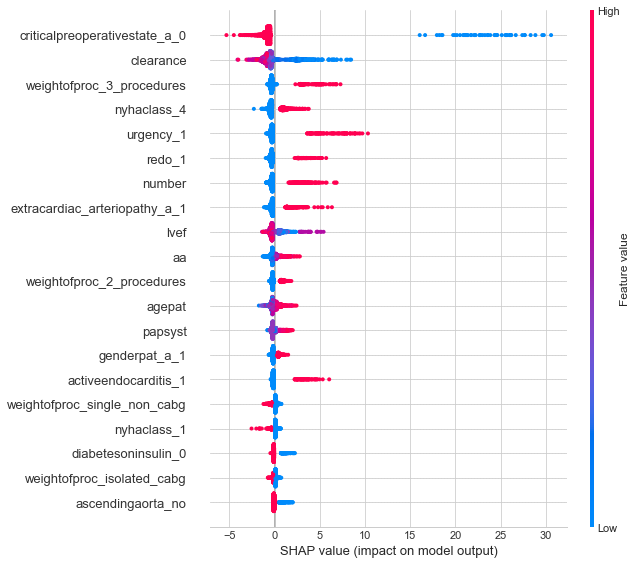

In [13]:
interpret_model(trained_model)

## Peso das features

O gráfico gerado nos mostra os recursos que contribuíram para a nossa previsão.
<br>As caracteríscias que empurram a previsão para cima são mostradas em vermelho e as que empurram a previsão para baixo estão em azul.

In [14]:
interpret_model(trained_model, plot = 'reason', observation = 10)

## Predição na base de validação

In [15]:
trained_model = load_model("trained_model")

Transformation Pipeline and Model Successfully Loaded


In [16]:
unseen_predictions_trained = predict_model(trained_model, data=data_validation)

In [17]:
unseen_predictions_trained.to_csv("data\processed\predictions_trained.csv", index=False)

In [18]:
unseen_predictions_trained = pd.read_csv("data\processed\predictions_trained.csv")

## Carregando dados de validação

In [19]:
predictions = unseen_predictions_trained.loc[unseen_predictions_trained.es2 >= 50]
es2 = predictions.es2
es2_predicted = predictions.Label

## Avaliação do modelo nos dados de validação

In [20]:
mae = metrics.mean_absolute_error(es2, es2_predicted)
mse = metrics.mean_squared_error(es2, es2_predicted)
r2 = metrics.r2_score(es2, es2_predicted)

print(f'MAE is {mae}')
print(f'MSE is {mse}')
print(f'R2 score is {r2}')

MAE is 13.313392626870243
MSE is 282.19260373943683
R2 score is -1.5418411994661052


## Plotando Previsto / Atual
Plotando previsto e original para os 26 valores que tiveram Euroscore originalmente maiores que 50

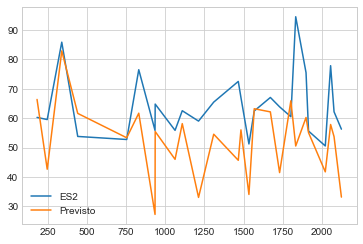

In [21]:
plt.plot(es2, label='ES2')
plt.plot(es2_predicted, label='Previsto')
plt.legend()
plt.show()

## Plotando diferenças entre valores originais e previstos

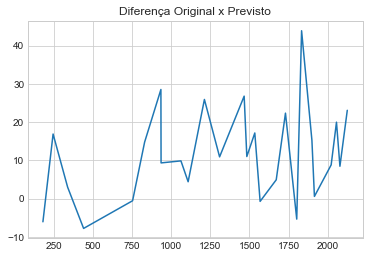

In [24]:
plt.title('Diferença Original x Previsto')
plt.plot(es2 - es2_predicted)
plt.show()